# Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from prettytable import PrettyTable

In [3]:
# sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from scipy.stats import mode
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Initialisation

In [6]:
naive_sub= pd.read_parquet('taxi/naive_submission.parquet')
df= pd.read_parquet('taxi/train.parquet')
test= pd.read_parquet('taxi/test.parquet')

# Préparation des données

In [8]:
columns = list(df.columns)
# Variable qualitative ou quantitative
quantitative_vars = ['passenger_count','trip_distance', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon', 'fare_amount', 'tolls_amount', 'extra']
qualitative_vars = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']
variable_cible = 'tip_amount'


# Supprime observation nombre de passagers = 8 de nos données
# Nous définissons un nouveau dataframe sur lequel nous faisons des transformations
df_filtered = df.copy()
index_8 = df_filtered[df_filtered['passenger_count']==7].index
df_filtered = df_filtered.drop(index_8, axis=0)

# Convertir en numérique les colonnes qui devraient l'être
for col in quantitative_vars:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

for col in qualitative_vars:
    df_filtered[col] = df_filtered[col].astype('category')

# Variable binaire
for col in ['store_and_fwd_flag','VendorID', 'mta_tax', 'congestion_surcharge', 'Airport_fee']:
    df_filtered[col] = pd.factorize(df_filtered[col])[0] + 1

# Variable improvement surcharge
df_filtered['improvement_surcharge'] = pd.factorize(df_filtered['improvement_surcharge'])[0] + 1

# RatecodeID en entiers
df_filtered['RatecodeID'] = df_filtered['RatecodeID'].astype(int)

# Convertir les autres colonnes en type "category" pour les colonnes catégorielles
for col in qualitative_vars:
    df_filtered[col] = df_filtered[col].astype('category')

# Convertion en format data heure
df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
df_filtered['tpep_dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])

# Régression

In [10]:
df_filtered = df_filtered.reset_index(drop=True)

### Données one hot encoded ###
X = df_filtered.drop(['tip_amount', 'tpep_pickup_datetime', 'tpep_dropoff_datetime'],axis=1)
y = df_filtered['tip_amount']

features = X.columns

## Feature scaling

In [12]:
# Transformé les données
ct_s = StandardScaler()
X_ss = X.copy()
X_ss[quantitative_vars] = ct_s.fit_transform(X_ss[quantitative_vars])
X_ss = pd.DataFrame(X_ss, columns=features)

# Transformé les données
ct_m = MinMaxScaler()
X_mm = X.copy()
X_mm[quantitative_vars] = ct_m.fit_transform(X_mm[quantitative_vars])
X_mm = pd.DataFrame(X_mm, columns=features)

## Entraînement modèles sans configuration

In [14]:
# Partionnement test-train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

features = X_train.columns

In [15]:
# Transformation des données pour répondre aux demandes de XGBoost
# One hot encode les variables catégorielles
def xgboost_data(df, categories):
    df_encoded = pd.get_dummies(df, columns = categories)
    return df_encoded

In [16]:
categories_for_xgb = ['VendorID', 
                      'RatecodeID', 
                      'store_and_fwd_flag', 
                      'payment_type', 
                      'mta_tax', 
                      'improvement_surcharge', 
                      'congestion_surcharge', 
                      'Airport_fee']

### Sur données de base

In [17]:
# Sur données originales

models = {
    "ElasticNet": ElasticNet(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(random_state=42, verbose=0),
    "CatBoost": CatBoostRegressor(random_seed=42, verbose=0, cat_features=categories_for_xgb),
    "Extra Trees Regressor": ExtraTreesRegressor(random_state=42)
}

mse_scores_default = {}
mae_scores_default = {}
r2_scores_default = {}
max_error_scores_default = {}

for method, model in models.items():
    print(method)
    if method == 'SVR':
        index = np.random.randint(0, len(X_train), 5000)
        X_train_subset = X_train.iloc[index]
        y_train_subset = y_train.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    elif method == 'XGBoost':
        X_train_xgb = xgboost_data(X_train, categories_for_xgb)
        base_model = model.fit(X_train_xgb, y_train)
    else:
        base_model = model.fit(X_train, y_train)

    if method == 'XGBoost':
        X_test_xgb = xgboost_data(X_test, categories_for_xgb)
        y_pred = base_model.predict(X_test_xgb)
    else: 
        y_pred = base_model.predict(X_test)
    
    # Calculate metrics correctly with y_test first
    mse_scores_default[method] = mean_squared_error(y_test, y_pred)
    mae_scores_default[method] = mean_absolute_error(y_test, y_pred)
    r2_scores_default[method] = r2_score(y_test, y_pred)
    max_error_scores_default[method] = max_error(y_test, y_pred)

ElasticNet
Random Forest Regressor
SVR
Gradient Boosting
XGBoost
LightGBM
CatBoost
Extra Trees Regressor


### Données normalisées

In [18]:
# Partionnement test-train
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_ss, y, test_size=0.3, random_state=42)

In [19]:
# Sur données Standardisées

mse_scores_default_ss = {}
mae_scores_default_ss = {}
r2_scores_default_ss = {}
max_error_scores_default_ss = {}

for method, model in models.items():
    print(method)
    if method == 'SVR':
        index = np.random.randint(0, len(X_train_ss), 10000)
        X_train_subset = X_train_ss.iloc[index]
        y_train_subset = y_train_ss.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    elif method == 'XGBoost':
        X_train_xgb = xgboost_data(X_train_ss, categories_for_xgb)
        base_model = model.fit(X_train_xgb, y_train)
    else:
        base_model = model.fit(X_train_ss, y_train_ss)

    if method == 'XGBoost':
        X_test_xgb = xgboost_data(X_test_ss, categories_for_xgb)
        y_pred = base_model.predict(X_test_xgb)
    else: 
        y_pred = base_model.predict(X_test_ss)
    
    # Calculate metrics correctly with y_test first
    mse_scores_default_ss[method] = mean_squared_error(y_test, y_pred)
    mae_scores_default_ss[method] = mean_absolute_error(y_test, y_pred)
    r2_scores_default_ss[method] = r2_score(y_test, y_pred)
    max_error_scores_default_ss[method] = max_error(y_test, y_pred)

ElasticNet
Random Forest Regressor
SVR
Gradient Boosting
XGBoost
LightGBM
CatBoost
Extra Trees Regressor


### Données Min-Max

In [20]:
# Partionnement test-train
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_mm, y, test_size=0.3, random_state=42)

In [21]:
# Sur données Min-Max

mse_scores_default_mm = {}
mae_scores_default_mm = {}
r2_scores_default_mm = {}
max_error_scores_default_mm = {}

for method, model in models.items():
    print(method)
    if method == 'SVR':
        index = np.random.randint(0, len(X_train_mm), 10000)
        X_train_subset = X_train_mm.iloc[index]
        y_train_subset = y_train_mm.iloc[index]
        base_model = model.fit(X_train_subset, y_train_subset)
    elif method == 'XGBoost':
        X_train_xgb = xgboost_data(X_train_mm, categories_for_xgb)
        base_model = model.fit(X_train_xgb, y_train)
    else:
        base_model = model.fit(X_train_mm, y_train_mm)

    if method == 'XGBoost':
        X_test_xgb = xgboost_data(X_test_mm, categories_for_xgb)
        y_pred = base_model.predict(X_test_xgb)
    else: 
        y_pred = base_model.predict(X_test_mm)
    
    # Calculate metrics correctly with y_test first
    mse_scores_default_mm[method] = mean_squared_error(y_test, y_pred)
    mae_scores_default_mm[method] = mean_absolute_error(y_test, y_pred)
    r2_scores_default_mm[method] = r2_score(y_test, y_pred)
    max_error_scores_default_mm[method] = max_error(y_test, y_pred)

ElasticNet
Random Forest Regressor
SVR
Gradient Boosting
XGBoost
LightGBM
CatBoost
Extra Trees Regressor


# Performance et comparaisons

In [22]:
# Toutes les métriques
table = PrettyTable()

table.field_names = ['Model', 'MSE', 'MAE', 'r2', 'Max error']

for model in mse_scores_default.keys():
    table.add_row([model, mse_scores_default.get(model, '-'), mae_scores_default.get(model, '-'), r2_scores_default.get(model, '-'), max_error_scores_default.get(model, '-')])

# Print the table
print(table)

table = PrettyTable()

table.field_names = ['Model', 'MSE', 'MAE', 'r2', 'Max error']

for model in mse_scores_default_ss.keys():
    table.add_row([model, mse_scores_default_ss.get(model, '-'), mae_scores_default_ss.get(model, '-'), r2_scores_default_ss.get(model, '-'), max_error_scores_default_ss.get(model, '-')])

# Print the table
print(table)

table = PrettyTable()

table.field_names = ['Model', 'MSE', 'MAE', 'r2', 'Max error']

for model in mse_scores_default_mm.keys():
    table.add_row([model, mse_scores_default_mm.get(model, '-'), mae_scores_default_mm.get(model, '-'), r2_scores_default_mm.get(model, '-'), max_error_scores_default_mm.get(model, '-')])

# Print the table
print(table)

+-------------------------+--------------------+--------------------+---------------------+-------------------+
|          Model          |        MSE         |        MAE         |          r2         |     Max error     |
+-------------------------+--------------------+--------------------+---------------------+-------------------+
|        ElasticNet       | 7.687211583237081  | 1.777332504416833  | 0.43837270410805695 | 86.39511263822578 |
| Random Forest Regressor | 4.6445640589171004 | 1.045816958039803  |  0.6606683808866785 |      86.0271      |
|           SVR           | 8.910132746877325  | 1.638231241264314  |  0.3490261447233761 | 85.47468476412352 |
|    Gradient Boosting    |  4.16564012412838  | 0.9928677908734345 |  0.6956585397395785 | 85.77938532290463 |
|         XGBoost         | 4.374233569957726  | 1.0094222258442542 |  0.6804187129631982 | 85.77312994003296 |
|         LightGBM        | 4.218133962473932  | 0.9881030654932231 |  0.6918233425212152 |  85.84130063

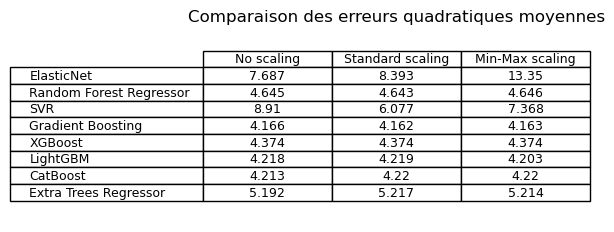

In [23]:
# Comparaison du mean squared error
mse_scores_default_all = [mse_scores_default.values(), mse_scores_default_ss.values(), mse_scores_default_mm.values()]
mse_scores_default_all = np.array([np.round(list(i),3) for i in mse_scores_default_all]).T

# Plot
fig, ax = plt.subplots(figsize=(5, 2.5)) 
ax.axis('off')

the_table = ax.table(cellText=mse_scores_default_all, colLabels=['No scaling', 'Standard scaling', 'Min-Max scaling'], rowLabels=list(models.keys()), loc='center',cellLoc='center')
plt.title('Comparaison des erreurs quadratiques moyennes')

plt.show()

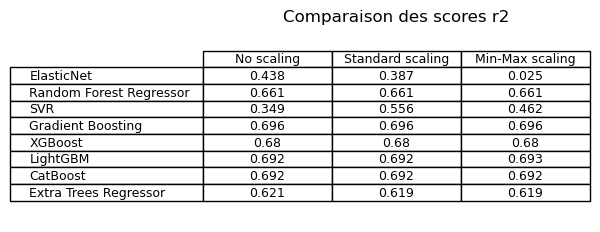

In [24]:
# Comparaison du r2 score
r2_scores_default_all = [r2_scores_default.values(), r2_scores_default_ss.values(), r2_scores_default_mm.values()]
r2_scores_default_all = np.array([np.round(list(i),3) for i in r2_scores_default_all]).T

# Plot
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.axis('off')

the_table = ax.table(cellText=r2_scores_default_all, colLabels=['No scaling', 'Standard scaling', 'Min-Max scaling'], rowLabels=list(models.keys()), loc='center',cellLoc='center')
plt.title('Comparaison des scores r2')

plt.show()